In [7]:
from sklearn import datasets
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

iris = datasets.load_iris()
X = pd.DataFrame(data=iris.data, columns=iris.feature_names)
X['target'] = list(map(lambda x: iris.target_names[x], iris.target))
y = pd.Series(iris.target, name='target')
X

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [8]:
y

0      0
1      0
2      0
3      0
4      0
      ..
145    2
146    2
147    2
148    2
149    2
Name: target, Length: 150, dtype: int32

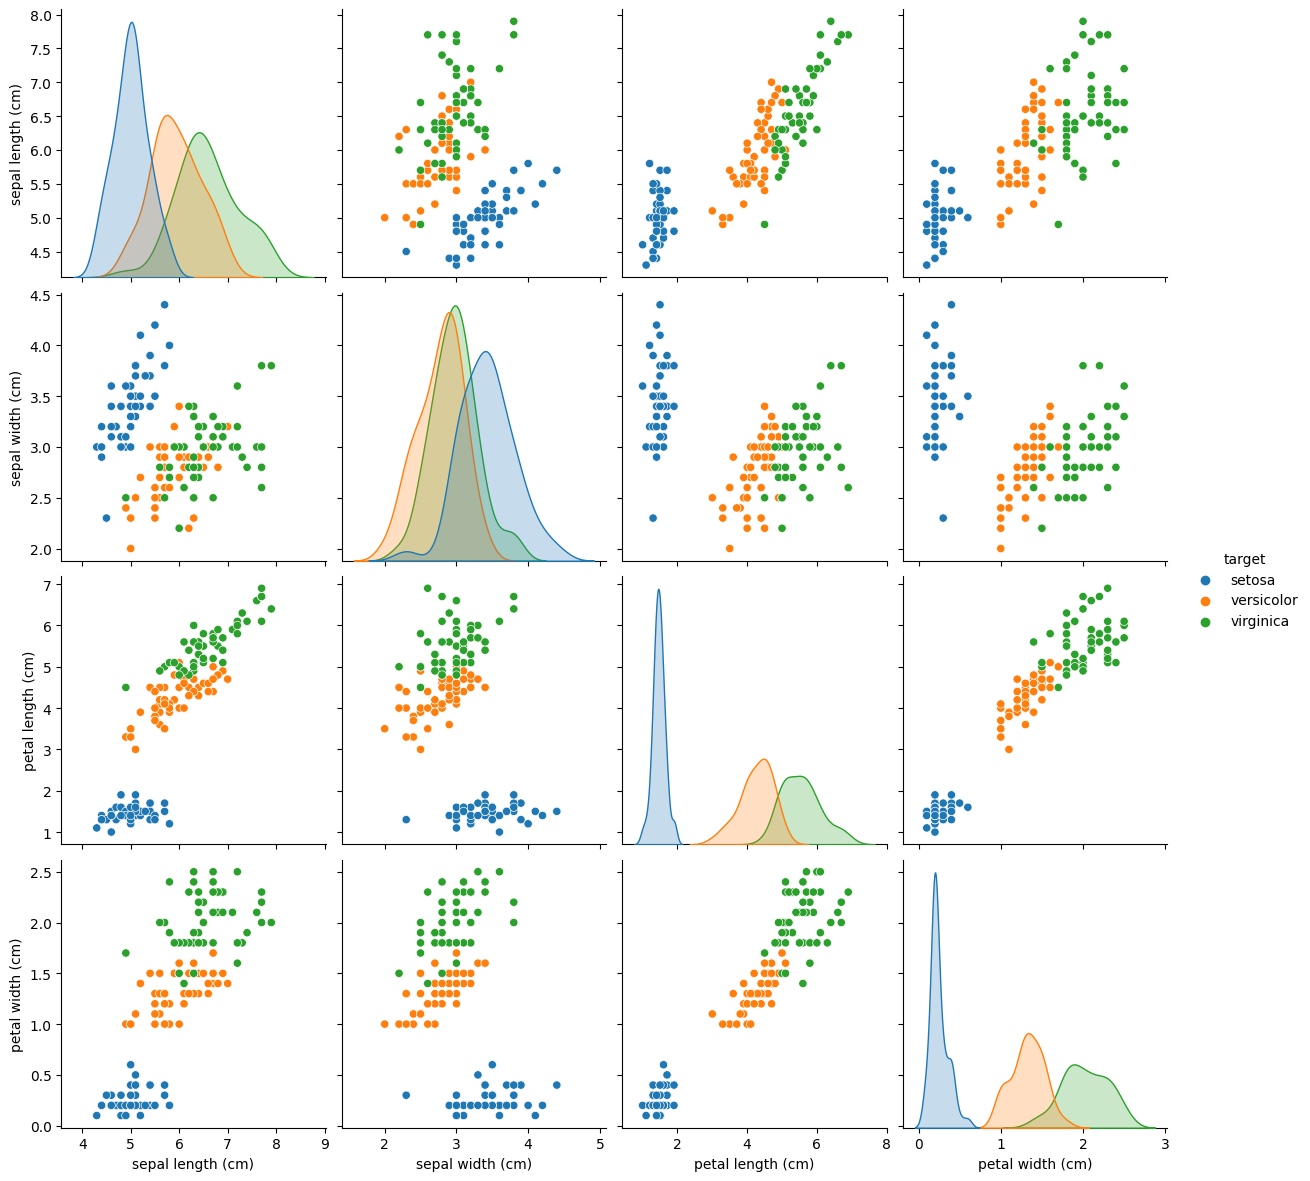

In [10]:
sns.pairplot(X, hue='target', height=3, diag_kind="kde")
plt.show()

In [15]:
from sklearn.preprocessing import StandardScaler

X_norm = pd.DataFrame(data=StandardScaler().fit_transform(X.drop('target', axis=1)), columns=iris.feature_names)
X_norm['target'] = X['target']
X_norm

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,-0.900681,1.019004,-1.340227,-1.315444,setosa
1,-1.143017,-0.131979,-1.340227,-1.315444,setosa
2,-1.385353,0.328414,-1.397064,-1.315444,setosa
3,-1.506521,0.098217,-1.283389,-1.315444,setosa
4,-1.021849,1.249201,-1.340227,-1.315444,setosa
...,...,...,...,...,...
145,1.038005,-0.131979,0.819596,1.448832,virginica
146,0.553333,-1.282963,0.705921,0.922303,virginica
147,0.795669,-0.131979,0.819596,1.053935,virginica
148,0.432165,0.788808,0.933271,1.448832,virginica


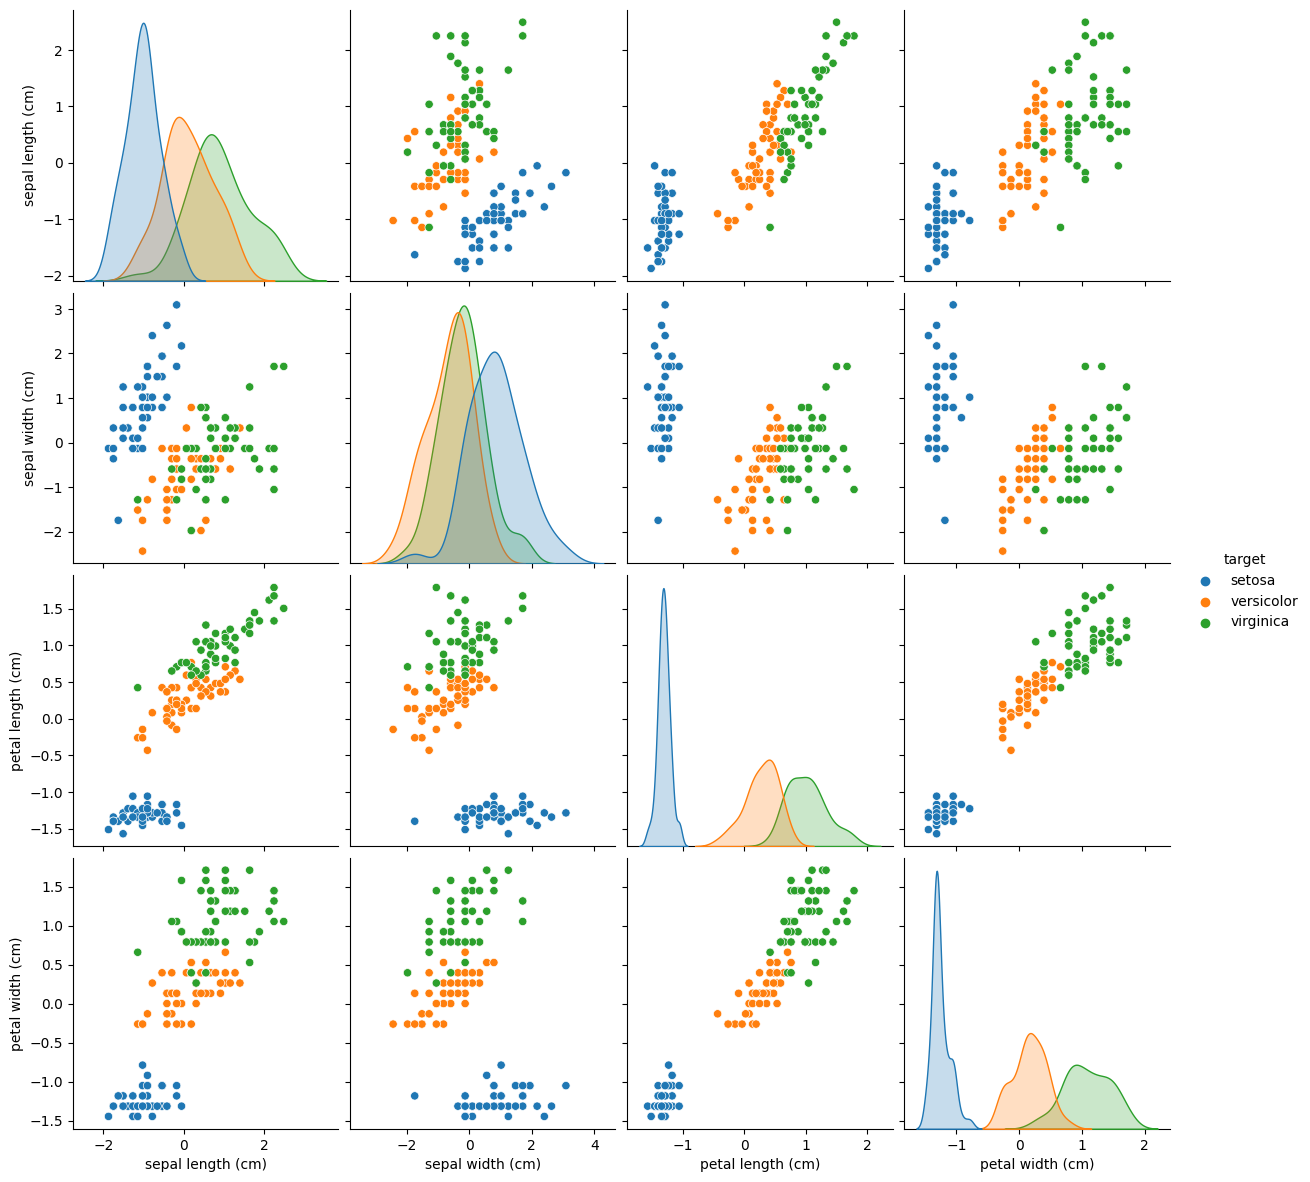

In [16]:
sns.pairplot(X_norm, hue='target', height=3, diag_kind="kde")
plt.show()